# Ray theoretical travel times and paths

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/tsonpham/ObsSeisHUS2025/blob/master/Day2/D2_Lab.ipynb)

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), April 2025.

---
## What do we do in this notebook
- Brief introduction of instrumental responses, and digital filter.
- Here we demonstrate `obspy taup` to predict travel times and ray paths in a spherical Earth's model.

Note: The content of this notebook follows closely the package [documentation](https://docs.obspy.org/packages/obspy.taup.html#basic-usage).

In [1]:
# Environemtal setup (uncomment if running in colab)

!pip install obspy numpy==1.26.4

In [2]:
#@title Run to activate retina display

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## Instrumental response, correction and digital filters

Yesterday, you learnd to download station metadata. Today, we learn to download seismic waveform and inspect it.

Inventory created at 2025-04-22T03:41:40.985900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?network=RM&station=S...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			RM
		Stations (1):
			RM.SLV (Son La Vietnam)
		Channels (3):
			RM.SLV..BHZ, RM.SLV..HHZ, RM.SLV..LHZ


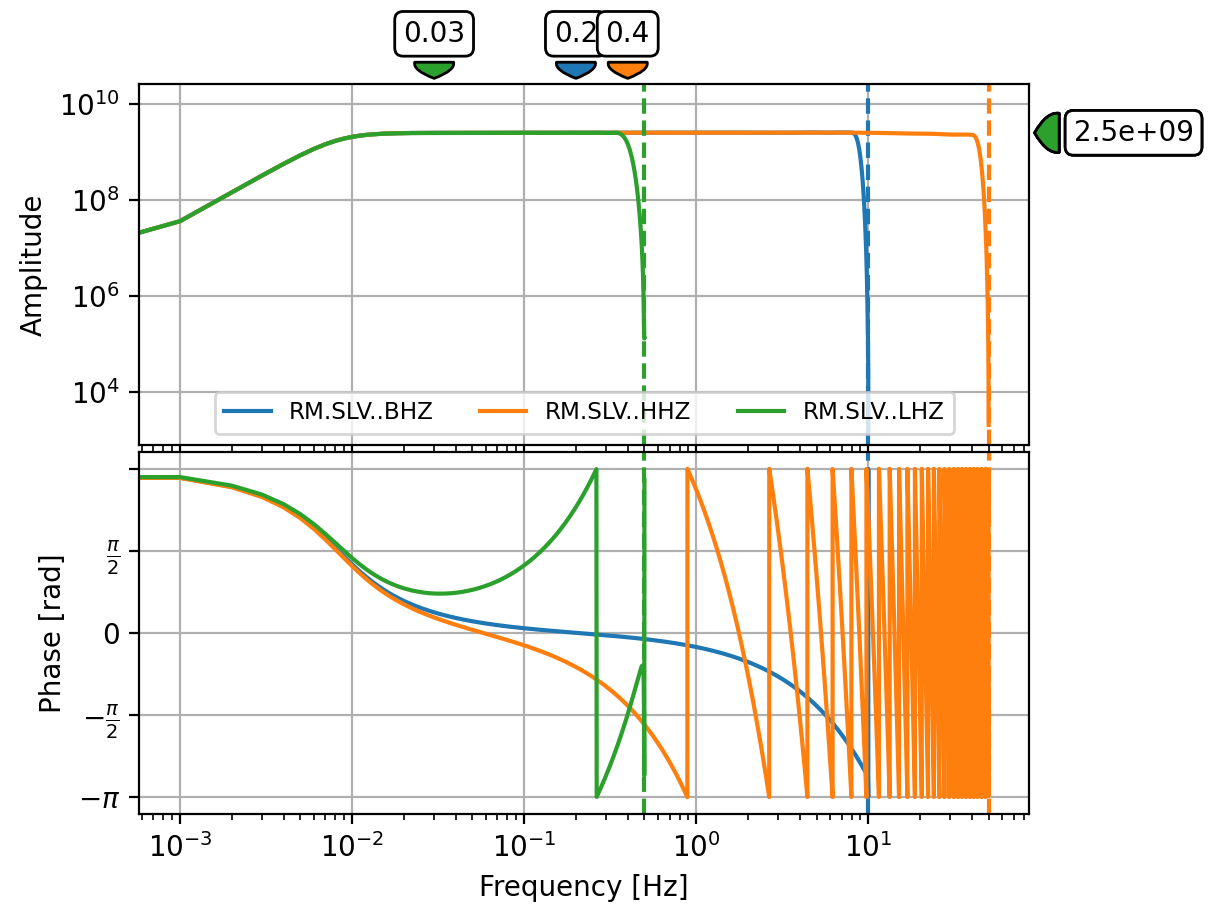

In [3]:
#@title here we download the stations including the instrumental response from station RM.SLV (Son La, Vietnam).
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt

inv = Client("IRIS").get_stations(network="RM", station="SLV", level="response")
print (inv.select(channel='?HZ'))
inv.plot_response(0.001, station="SLV", channel="?HZ")
plt.show()

Station SLV has three vertical channels, LHZ, BHZ, and HHZ. The channel names follow this [naming convention](https://docs.fdsn.org/projects/source-identifiers/en/latest/channel-codes.html#seismometer).

For example, in `LHZ` channel name:
- L is the bandcode, meaning it's a long period sensor (~1 second)
- H is the source code, meaning it's a high gain sensor (more sensitive)
- Z is the subsource code, meaning it's a vertical component

Unfortunately, this station does not record ground motions of the M5.2 Kon Tum 28/07/2024 earthquake. Later we consider data from station `PS.VIVO` to demonstrate the effect of instrumental response.

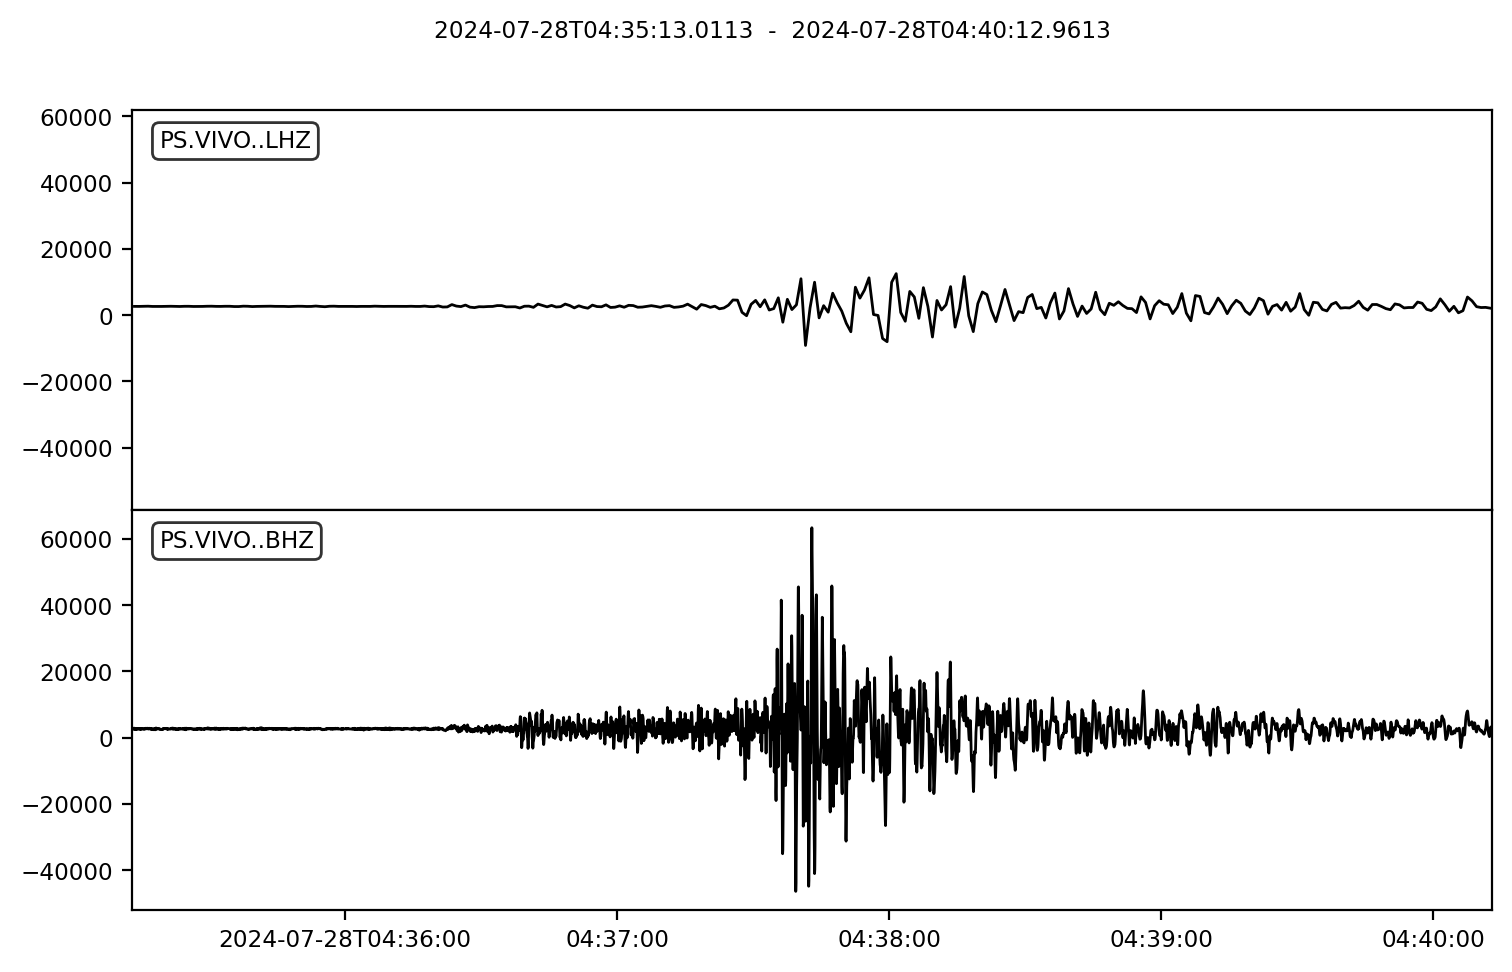

In [4]:
#@title Download all high-gain vertical channels from station PS.VIVO (Vinh, VN) for 5 minutes from the origin time
from obspy import UTCDateTime

starttime = UTCDateTime("2024-07-28T04:35:13")
endtime = UTCDateTime("2024-07-28T04:40:13")

dstream = Client("IRIS").get_waveforms(
    network="PS",
    station="VIVO",
    channel="?HZ",
    location="*",
    starttime=starttime,
    endtime=endtime,
    attach_response=True)
dstream.plot()
plt.show()

If `attach_response=True` is set, the response will be attached to the stream. This means that the response will be removed when you call `dstream.remove_response()`.

Original seismometer output are time series of integer vontage counts. You need to `remove_response()` to obtain the physical measurements (i.e., displacement, velocity or acceleration) of ground motions.

Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 2.01329e+09 defined at 0.020 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 1200
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 1.67772e+06
		Stage 3: CoefficientsTypeResponseStage from counts to counts, gain: 1


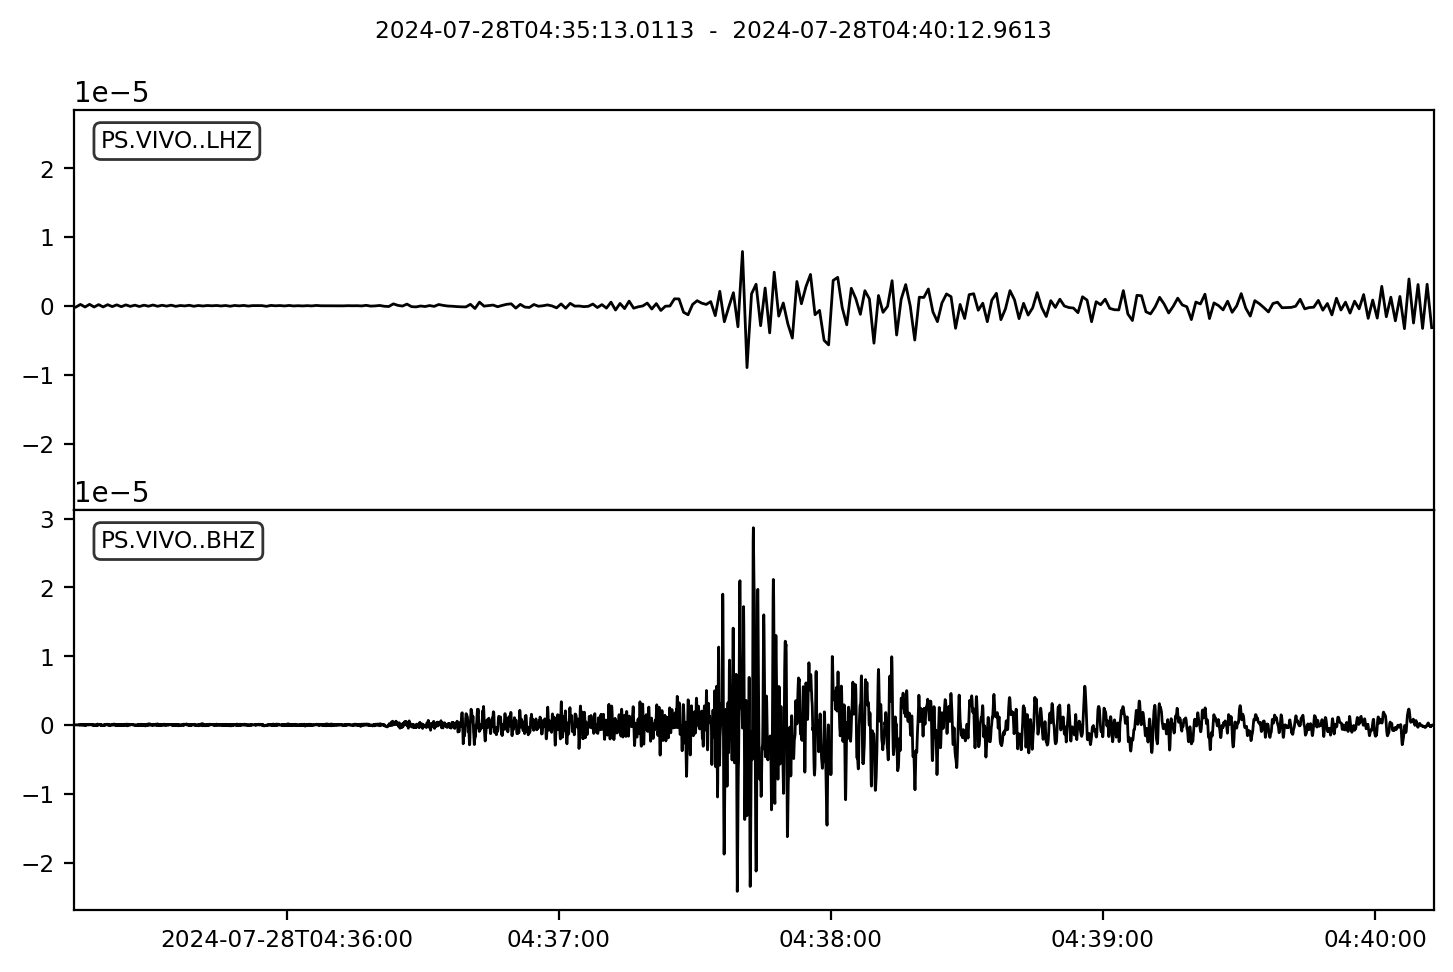

In [5]:
print (dstream[0].stats.response)

dstream.remove_response(output="VEL") # remove the instrument response to ground velocity in m/s
dstream.plot()

plt.show()

Do you notice the visual difference in the two seismograms? This is because their sensor have different bands. If they are filtered in the same bandwidths, they are very similar.

2 Trace(s) in Stream:
PS.VIVO..BHZ | 2024-07-28T04:35:13.011300Z - 2024-07-28T04:40:12.961300Z | 20.0 Hz, 6000 samples
PS.VIVO..LHZ | 2024-07-28T04:35:13.511300Z - 2024-07-28T04:40:12.511300Z | 1.0 Hz, 300 samples


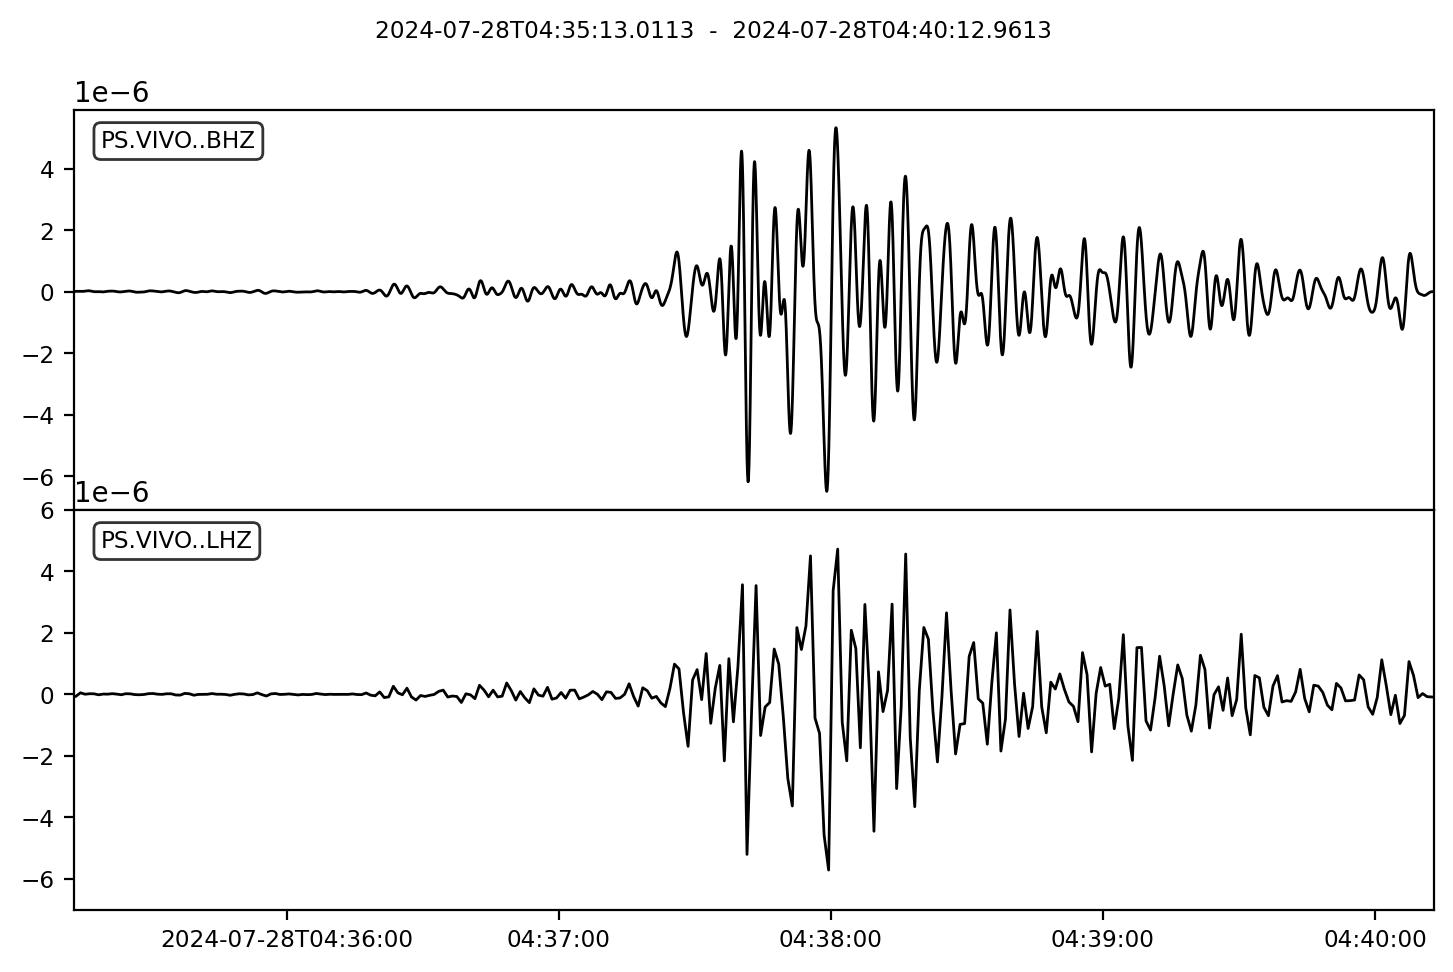

In [6]:
print (dstream)

dstream.filter('bandpass', freqmin=0.01, freqmax=0.4, corners=4, zerophase=True)
dstream.plot()
plt.show()

---
## Conversion between distances in kms and degrees

In passive seismology, it is conventionally convenient to work with angular distances in degrees rather than kilometers. The conversions between the two quantities uses the nominal radius of the Earth, $R = 6371$ km. One degree along the Earth's circumference, often called as the great circle path, is $\dfrac{2 \pi \times R \; (km)}{360^\circ} \approx 111.195\; km/^\circ$.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

R = 6371
C = 2 * 3.14159265359 * R
KMPERDEG = C / 360
print(f"Distance in kms = distance in degrees times {np.round(KMPERDEG, 3)} (km/deg).")

Distance in kms = distance in degrees times 111.195 (km/deg).


---
## Travel Times

[`get_travel_time()`](https://docs.obspy.org/packages/autogen/obspy.taup.tau.TauPyModel.get_travel_times.html#obspy.taup.tau.TauPyModel.get_travel_times) method predicts the travel time of a chosen seismic phase from a source at depth, in kms, over a distance, in degrees.


In [8]:
# Import obspy.taup and initialize a taup model
from obspy.taup import TauPyModel
# iasp91 is the default model, which can be changed to others, ak135 or prem are often used alternatives
model = TauPyModel(model="iasp91")

# Output of get_travel_times() method is a list of seismic arrivals
arrivals = model.get_travel_times(source_depth_in_km=10, distance_in_degree=30)

print ("List all possible phases (when `phase_list` not specified) existing for a seismic source at 10 km depth and distance at 30 degree:")
print(arrivals) # Print the list of seismic arrivals

List all possible phases (when `phase_list` not specified) existing for a seismic source at 10 km depth and distance at 30 degree:
35 arrivals
	P phase arrival at 368.735 seconds
	pP phase arrival at 371.793 seconds
	sP phase arrival at 373.132 seconds
	PP phase arrival at 425.245 seconds
	PP phase arrival at 425.281 seconds
	PP phase arrival at 425.604 seconds
	PP phase arrival at 436.405 seconds
	PP phase arrival at 436.522 seconds
	PcP phase arrival at 550.512 seconds
	S phase arrival at 667.645 seconds
	pS phase arrival at 671.257 seconds
	sS phase arrival at 672.887 seconds
	SP phase arrival at 673.390 seconds
	PS phase arrival at 675.022 seconds
	SP phase arrival at 691.586 seconds
	SP phase arrival at 691.625 seconds
	PS phase arrival at 693.925 seconds
	PS phase arrival at 693.932 seconds
	SS phase arrival at 760.654 seconds
	ScP phase arrival at 772.722 seconds
	PcS phase arrival at 773.985 seconds
	SS phase arrival at 795.729 seconds
	SS phase arrival at 795.816 seconds
	PKiK

If seismic phases are not specified, all possible arrivals at 30° epicentral distance will be calculated and returned. One can use `phase_list` parameter to specify the list of [seismic phases](https://docs.obspy.org/packages/obspy.taup.html#phase-naming-in-obspy-taup) of interest.

6 arrivals
	PP phase arrival at 425.245 seconds
	PP phase arrival at 425.281 seconds
	PP phase arrival at 425.604 seconds
	PP phase arrival at 436.405 seconds
	PP phase arrival at 436.522 seconds
	S phase arrival at 667.645 seconds


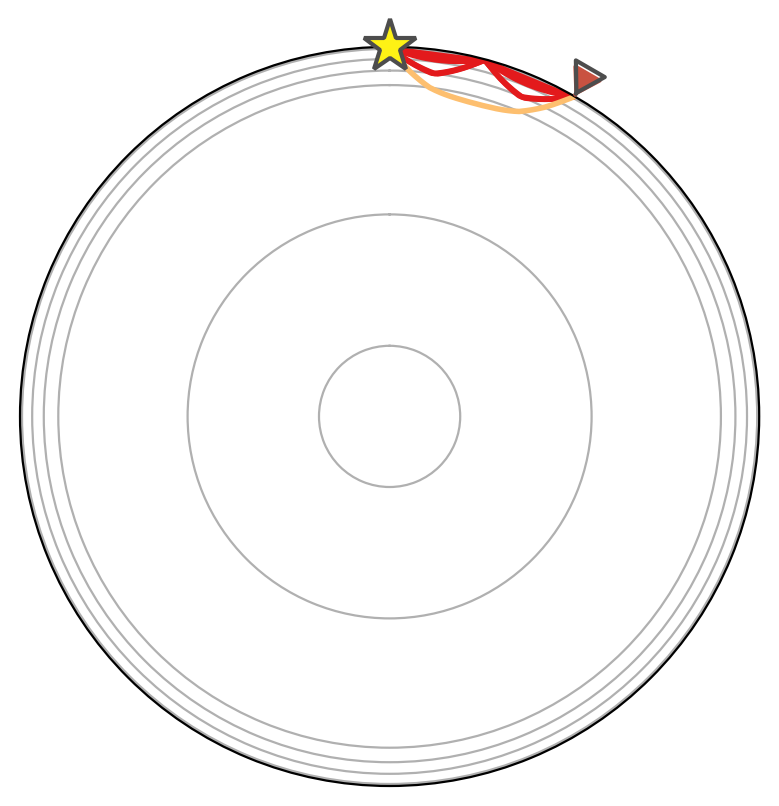

In [10]:
arrivals = model.get_ray_paths(source_depth_in_km=10, distance_in_degree=30, phase_list=["PP", "S"])
print (arrivals)
arrivals.plot_rays()
plt.show()

The method returns one arrival each for P and S waves at the configuration described above. Let inspect the arrivals and show more information!

In [11]:
for arrival in arrivals:
    print ("_________________________")
    print (f"Phase name: {arrival.name}")
    print (f"Arrival time: {arrival.time:.2f} seconds")
    print (f"Distance: {arrival.distance}°")
    print (f"Take-off angle: {arrival.takeoff_angle:.2f}°")
    print (f"Ray parameter: {arrival.ray_param:.2f} (s/rad) = {arrival.ray_param/R:.2f} (s/km)")

_________________________
Phase name: PP
Arrival time: 425.24 seconds
Distance: 30°
Take-off angle: 45.39°
Ray parameter: 780.73 (s/rad) = 0.12 (s/km)
_________________________
Phase name: PP
Arrival time: 425.28 seconds
Distance: 30°
Take-off angle: 43.54°
Ray parameter: 755.49 (s/rad) = 0.12 (s/km)
_________________________
Phase name: PP
Arrival time: 425.60 seconds
Distance: 30°
Take-off angle: 44.89°
Ray parameter: 774.02 (s/rad) = 0.12 (s/km)
_________________________
Phase name: PP
Arrival time: 436.40 seconds
Distance: 30°
Take-off angle: 35.48°
Ray parameter: 636.63 (s/rad) = 0.10 (s/km)
_________________________
Phase name: PP
Arrival time: 436.52 seconds
Distance: 30°
Take-off angle: 35.93°
Ray parameter: 643.52 (s/rad) = 0.10 (s/km)
_________________________
Phase name: S
Arrival time: 667.64 seconds
Distance: 30°
Take-off angle: 28.31°
Ray parameter: 897.68 (s/rad) = 0.14 (s/km)


The ray parameter, defined as $\dfrac{\sin i}{v}$, is constant along the ray path according to the Snell's law. Because the ray parameter is inversely propotional to speed, it is also refered as *slowness*. The take-off angle, as its name suggested, is the angle of the ray path when it leaves the source.

---
## Ray Paths
We can also calulate the path of a seismic ray propagating in a spherical Earth model using `get_ray_paths()`. The following cell calculates the ray paths of seismic arrivals from a seismic source placed at 10 km depth to a receiver at 30° epicentral distance.

In [12]:
arrivals = model.get_ray_paths(source_depth_in_km=10, distance_in_degree=30,
                               # ttbasic is not a standard phase name, but refers to a group of basic phases
                               phase_list=["ttbasic"])
print (arrivals[0].path.dtype)

[('p', '<f8'), ('time', '<f8'), ('dist', '<f8'), ('depth', '<f8')]


Now, the ray path for each arrival is stored in `path` field. Note the `path` field is  `None` or empty if `get_travel_times()` was used. This field is a list of tuples each constains the unique ray parameter `p`, travel time `time`, distance `dist`, and depth `depth` of each calculation nodes along the ray path.

One can used `get_ray_paths_geo()` to calculate ray paths use source and receiver's latitudes and longitudes. If `geographiclib` library (used pip install geographiclib) is installed, the `path` field tuples have six rather than four items, with additional lat and lon of each discrete steps.

Use function `arrivals.plot_rays()` to see the ray paths in a cross section of the Earth.

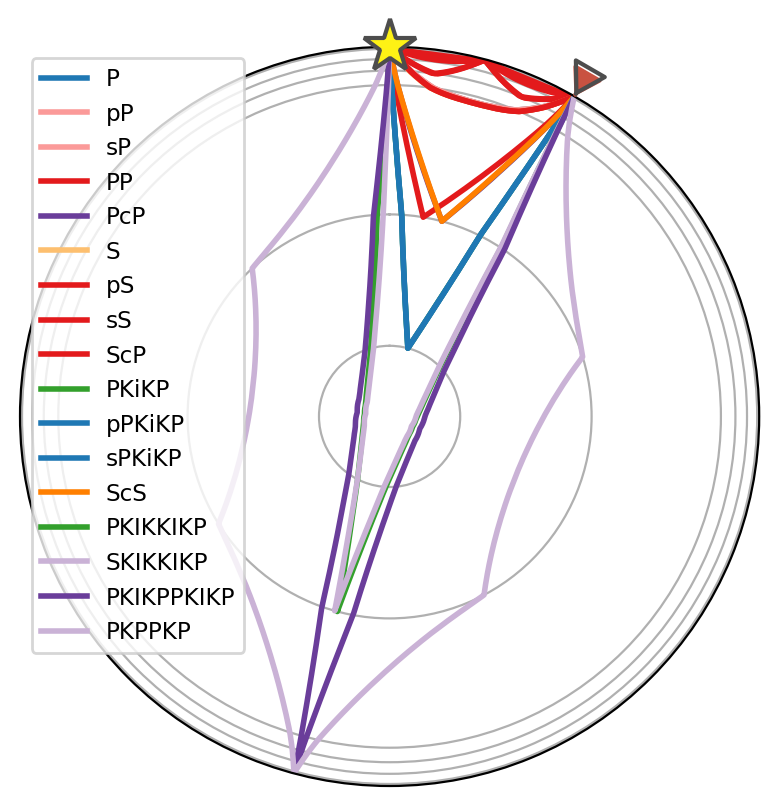

In [13]:
arrivals.plot_rays(plot_type="spherical", legend=True)
plt.show()

The ray paths also be plotted in a flatten Earth when `plot_type` is set to `catersian`.

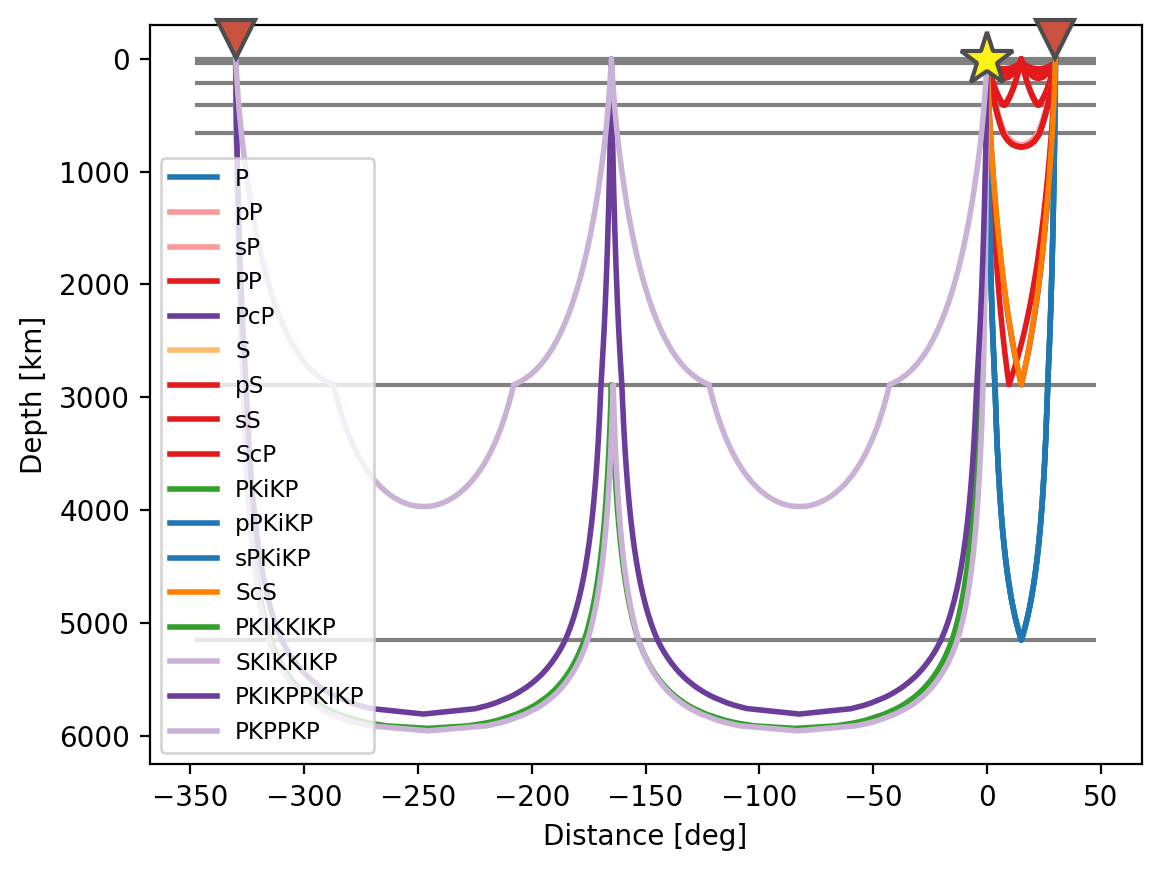

In [14]:
arrivals.plot_rays(plot_type="cartesian", legend=True)
plt.show()

---
## Travel Time Curves

The ray path of a seismic phase from source to receiver is deteministic in an Earth model and is function of epicentral distance and source depth. Given the same source depth, a travel time curve represents the variation of travel times as function of epicentral distances.

Please refer to this page [Travel Time Curves: How they are created](https://www.iris.edu/hq/inclass/animation/traveltime_curves_how_they_are_created) for more information.

Let's consider the travel of P waves from a source on the Earth surface, i.e., depth = 0 km, to an arrange of seismic array equally distributed from 10 to 50 degrees.

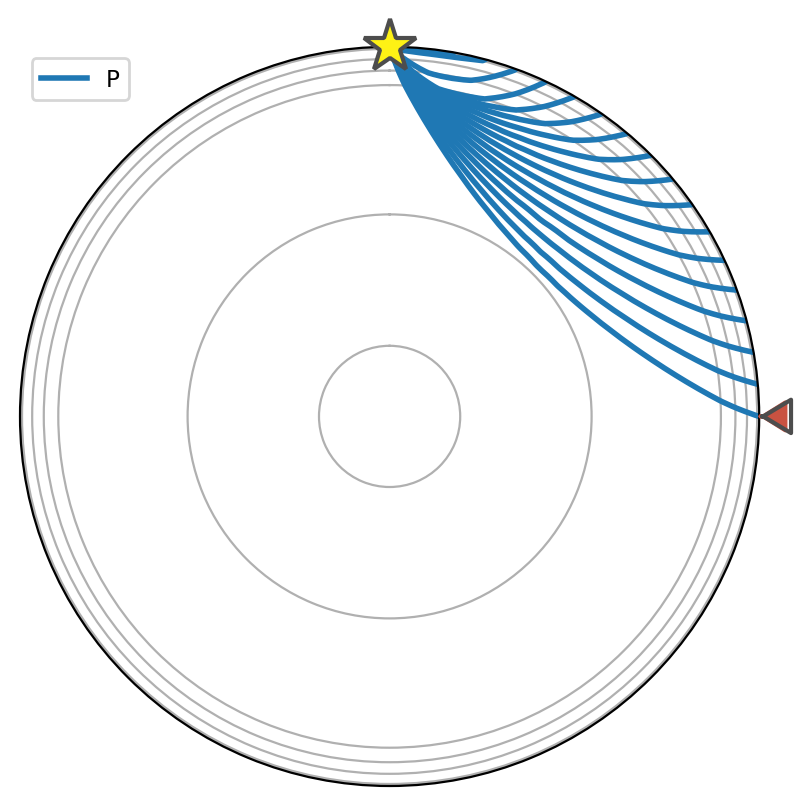

In [15]:
from obspy.taup.tau import Arrivals
list_of_distances = np.arange(0, 91, 5)
list_of_arrivals = []
for dist in list_of_distances:
    arrivals = model.get_ray_paths(source_depth_in_km=0, distance_in_degree=dist, phase_list=["P"])
    list_of_arrivals.append(arrivals[0]) # append arrivals to list for every 5 degrees
arrivals = Arrivals(list_of_arrivals, model.model) # create an Arrivals object
arrivals.plot_rays(plot_type="spherical", legend=True)
plt.show()

And, the travel time curve is

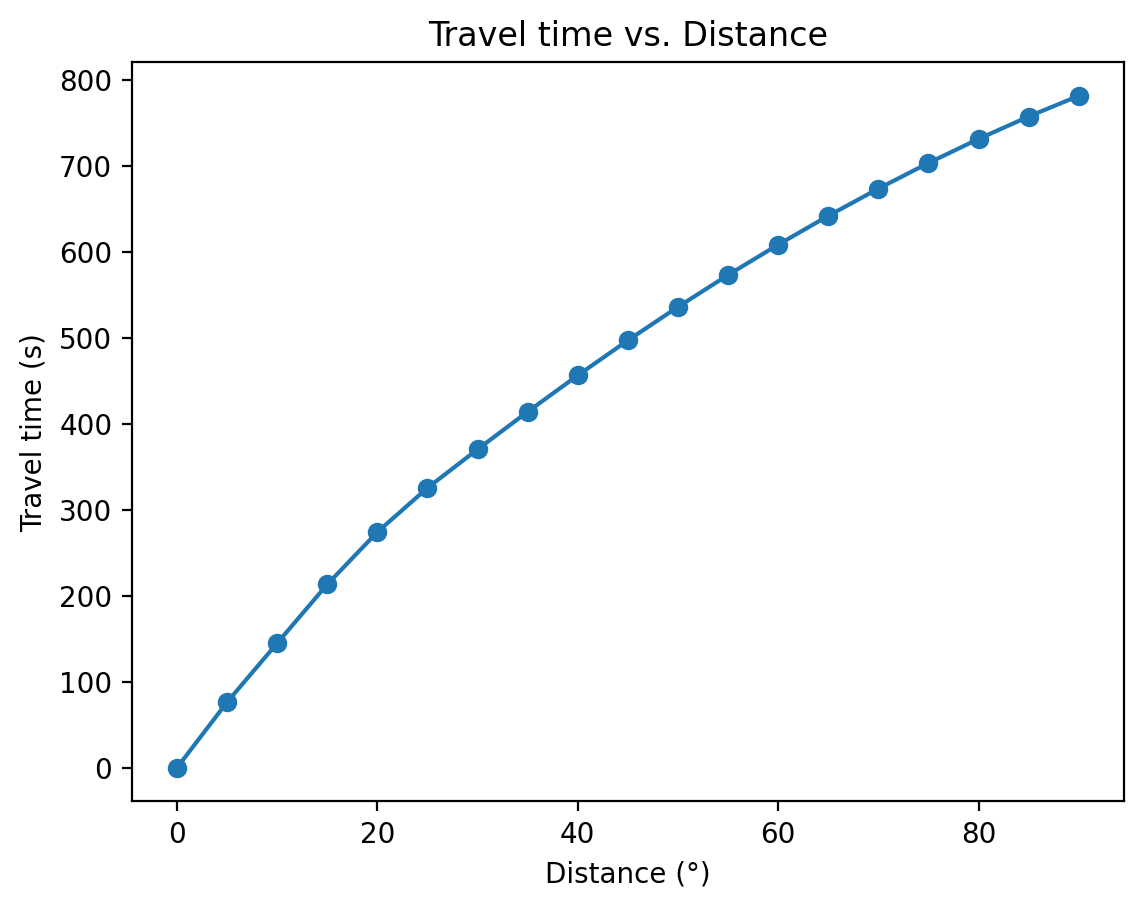

In [16]:
list_of_ttimes = []
for arrivals in list_of_arrivals:
    list_of_ttimes.append(arrivals.time)
plt.plot(list_of_distances, list_of_ttimes, "o-")
plt.xlabel("Distance (°)")
plt.ylabel("Travel time (s)")
plt.title("Travel time vs. Distance")
plt.show()

Note that, the P-wave's travel time curve above has been calculated at a discrete collection of epicentral distances and the calculation time is propotional to the desired number of distances. To avoid unnecessary computation, the calculated points can be interpolated to get the travel time for an arbitrary epicentral distance.

In [17]:
# Interpolated function for travel time vs. distance
P_time = 50
dist = np.interp(P_time, list_of_ttimes, list_of_distances)
# What's the epicentral distance if P-wave takes 50 seconds to travel from source to receiver?
print (f"Distance for {P_time} seconds: {dist:.2f}° or {dist*KMPERDEG:.2f} km")

Distance for 50 seconds: 3.28° or 364.46 km


Have you notice that the slop of the travel time curve as unit of `s/°`, which is the unit of ray parameter, also know as slowness?! Indeed, the slope of the travel time curve at a given distance is the ray parameter of its travel ray path. This proof can be found in any seismological textbook, for example Stein & Wysession (2003), but remains beyond the scope of this introductory workshop.

---
## Challenge 1

Let's try what you have learned!

In the example above, you are determined to determine the epicentral distance given a measured P-wave travel time. Now we look at how we can calculate the distance given the measured difference between S and P-wave arrivals.  To complete this excercise, please copy the following code blocks to a new Python cell, replace all <CHANGE ME> instances with your codes.

```
# Add your name to show in the plot title
your_name = <CHANGE ME>

# Calculate travel times for P and S waves for distances from 0 to 20 degrees
distances = np.arange(21)
P_times = [] # List to store P-wave travel times
S_times = [] # List to store S-wave travel times
for dist in distances:
    # Calculate and save P-wave travel time
    arrivals = <CHANGE ME>
    P_times.append(arrivals[0].time)
    # Calculate and save S-wave travel time
    arrivals = model.get_travel_times(0, dist, ["S"])
    S_times.<CHANGE ME>

# Convert lists to numpy arrays for easy manipulation
P_times = np.array(P_times)
S_times = np.array(S_times)

# Use numpy.interp() to interpolate distance for a given differential travel time (ΔT)
dtime = 100
dist = np.interp(dtime, S_times-P_times, distances)

# Calculate P and S wave travel times for the interploated distance
P_time = <CHANGE ME>
S_time = <CHANGE ME>

# Plot the results
fig, ax = plt.subplots()
ax.plot(distances, S_times, "-", label="S-wave")
ax.plot(distances, P_times, "-", label="P-wave")
ax.axvline(x=dist, color="black", linestyle="--", lw=0.75)
ax.annotate("", xy=(dist, S_time), xytext=(dist, P_time), arrowprops=dict(arrowstyle="<|-|>"))
ax.text(dist+.2, (P_time+S_time)/2, f"ΔT = {dtime:.0f} s")
ax.set(xlabel="Distance (°)", ylabel="Travel time (s)", title=f"Travel time curve by {your_name}")
ax.text(dist+.2, 0, f"D = {dist:.2f}°")
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()
```

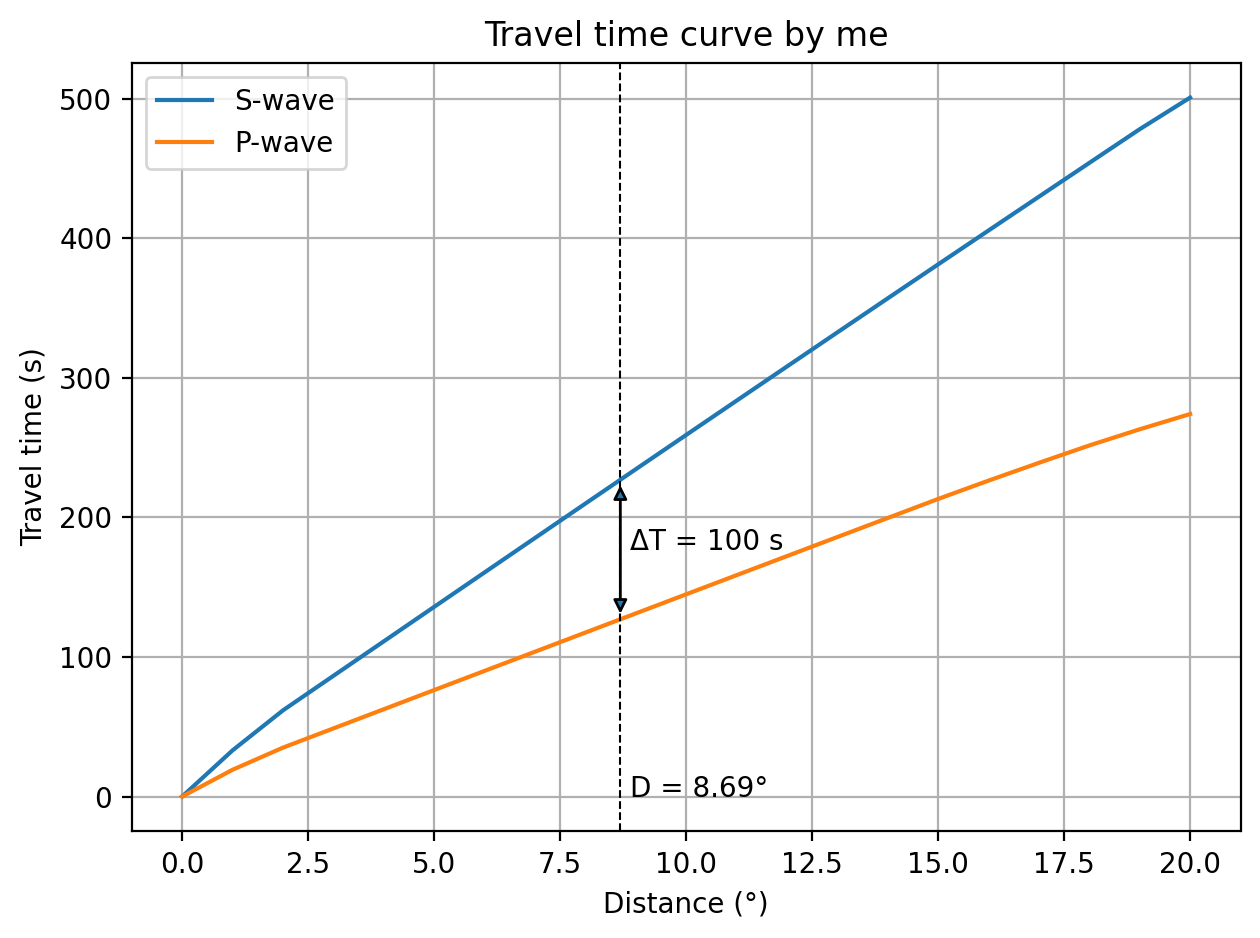

In [19]:
## Enter your code here & Replace <CHANGE ME> with your code
distances = np.arange(21)
P_times = [] # List to store P-wave travel times
S_times = [] # List to store S-wave travel times
for dist in distances:
  # Calculate P-wave travel time
  arrivals = model.get_travel_times(0, dist, ["P"])
  P_times.append(arrivals[0].time)
  # Calculate S-wave travel time
  arrivals = model.get_travel_times(0, dist, ["S"])
  S_times.append(arrivals[0].time)

# Convert lists to numpy arrays for easy manipulation
P_times = np.array(P_times)
S_times = np.array(S_times)

# Use numpy.interp() to interpolate distance for a given differential travel time (ΔT)
dtime = 100
dist = np.interp(dtime, S_times-P_times, distances)

# Calculate P and S wave travel times for the interpolated distance
P_time = np.interp(dist, distances, P_times)
S_time = np.interp(dist, distances, S_times)

# Plot the results
fig, ax = plt.subplots()
ax.plot(distances, S_times, "-", label="S-wave")
ax.plot(distances, P_times, "-", label="P-wave")
ax.axvline(x=dist, color="black", linestyle="--", lw=0.75)
ax.annotate("", xy=(dist, S_time), xytext=(dist, P_time),
            arrowprops=dict(arrowstyle="<|-|>"))
ax.text(dist+.2, (P_time+S_time)/2, f"ΔT = {dtime:.0f} s")
ax.set(xlabel="Distance (°)", ylabel="Travel time (s)", title="Travel time curve by me")
ax.text(dist+.2, 0, f"D = {dist:.2f}°")
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

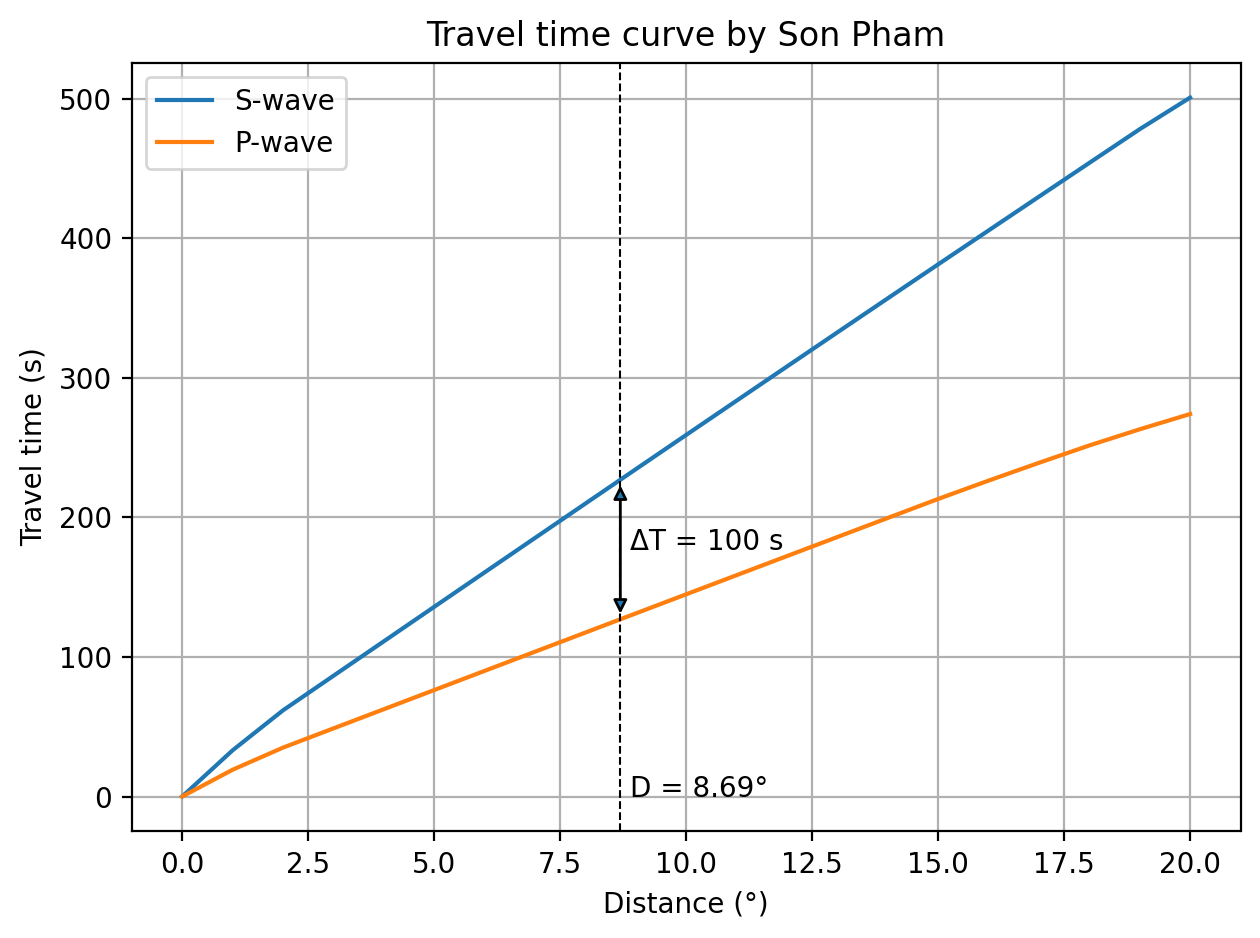

In [20]:
#@title Click for solution

# Add your name to show in the plot title
your_name = "Son Pham"

# Calculate travel times for P and S waves for distances from 0 to 20 degrees
distances = np.arange(21)
P_times = [] # List to store P-wave travel times
S_times = [] # List to store S-wave travel times
for dist in distances:
    # Calculate and save P-wave travel time
    arrivals = model.get_travel_times(0, dist, ["P"])
    P_times.append(arrivals[0].time)
    # Calculate and save S-wave travel time
    arrivals = model.get_travel_times(0, dist, ["S"])
    S_times.append(arrivals[0].time)

# Convert lists to numpy arrays for easy manipulation
P_times = np.array(P_times)
S_times = np.array(S_times)

# Use numpy.interp() to interpolate distance for a given differential travel time (ΔT)
dtime = 100
dist = np.interp(dtime, S_times-P_times, distances)

# Calculate P and S wave travel times for the interploated distance
P_time = np.interp(dist, distances, P_times)
S_time = np.interp(dist, distances, S_times)

# Plot the results
fig, ax = plt.subplots()
ax.plot(distances, S_times, "-", label="S-wave")
ax.plot(distances, P_times, "-", label="P-wave")
ax.axvline(x=dist, color="black", linestyle="--", lw=0.75)
ax.annotate("", xy=(dist, S_time), xytext=(dist, P_time), arrowprops=dict(arrowstyle="<|-|>"))
ax.text(dist+.2, (P_time+S_time)/2, f"ΔT = {dtime:.0f} s")
ax.set(xlabel="Distance (°)", ylabel="Travel time (s)", title=f"Travel time curve by {your_name}")
ax.text(dist+.2, 0, f"D = {dist:.2f}°")
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

---
## Challenge 2
The travel time curves plotted above are calculated for the first arrival only. Given that you have some understanding of seismic travel time curves, let's try to follow the instruction of function `plot_travel_times` [link](https://docs.obspy.org/packages/autogen/obspy.taup.tau.plot_travel_times.html) to plot the travel time curves of PKP and PKIKP phases from a source at 50 km depth. Feel free to experiment with different Earth's models such as `ak135` or `prem`. You might want to plot their ray paths at 153° to have some clues of what's happening.

You will probably see two PKP ray paths connecting the source and receiver? Do you think it conflicts with the Fermat's [pinciple](https://www.britannica.com/science/Fermats-principle)?

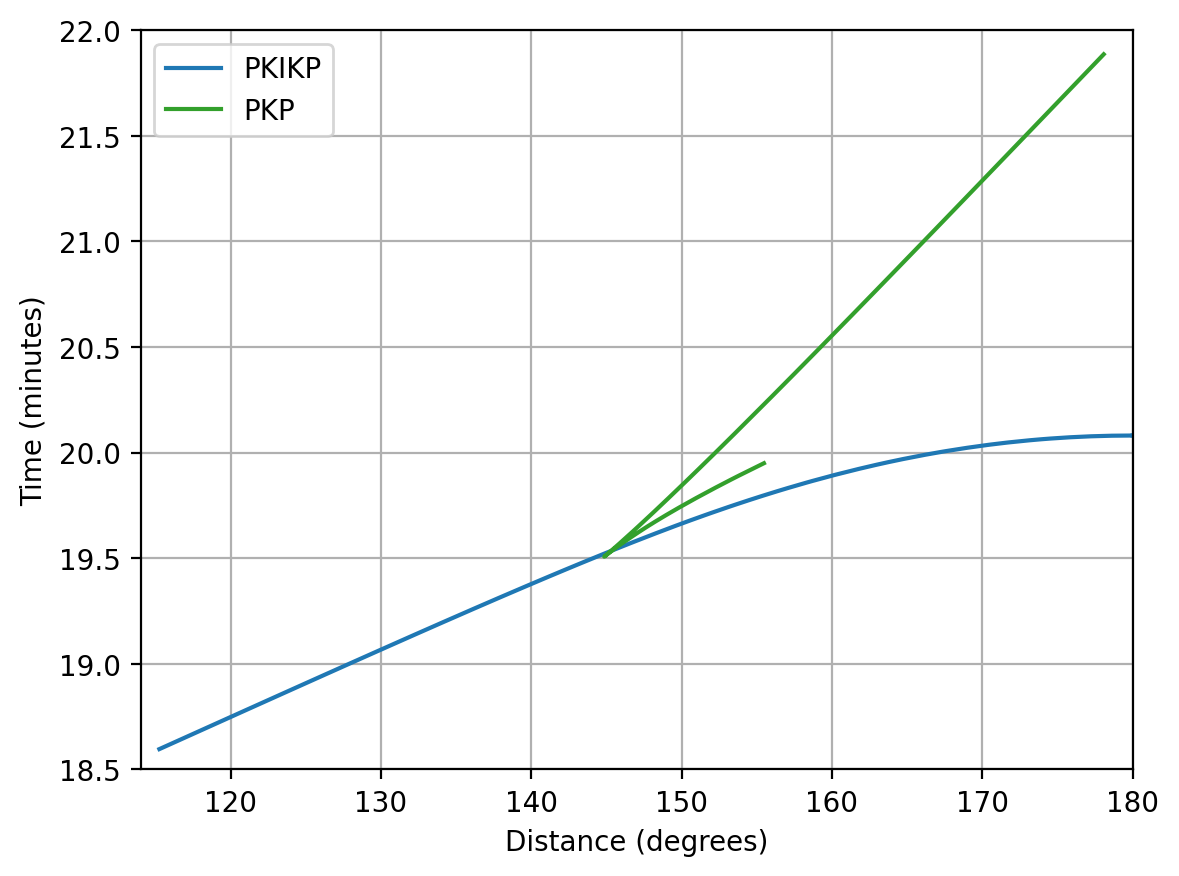

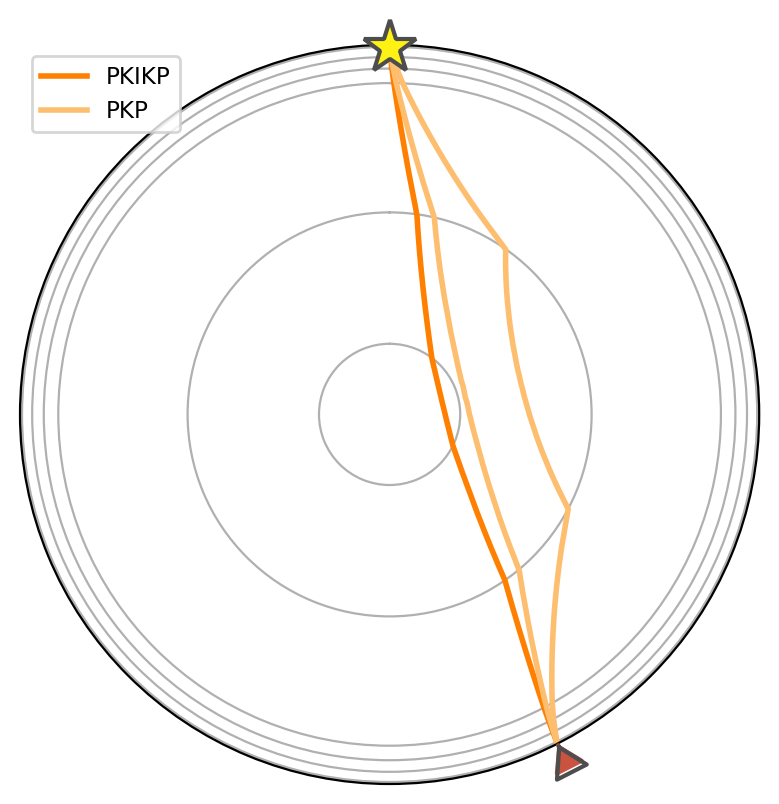

In [32]:
# Enter your code here
from obspy.taup import plot_travel_times
fig,ax = plt.subplots()

# Plot travel times for PKP and PKIKP phases
plot_travel_times(source_depth=50, phase_list=["PKP", "PKIKP"], model="ak135", show=False, ax=ax,
                  min_degrees=114, max_degrees=180)
ax.set(ylim=(18.5, 22))

# plot the ray path for PKP and PKIKP wave
arrivals = model.get_ray_paths(source_depth_in_km=50, distance_in_degree=153, phase_list=["PKP", "PKIKP"])
arrivals.plot_rays(plot_type="spherical", legend=True, show=False)
plt.show()

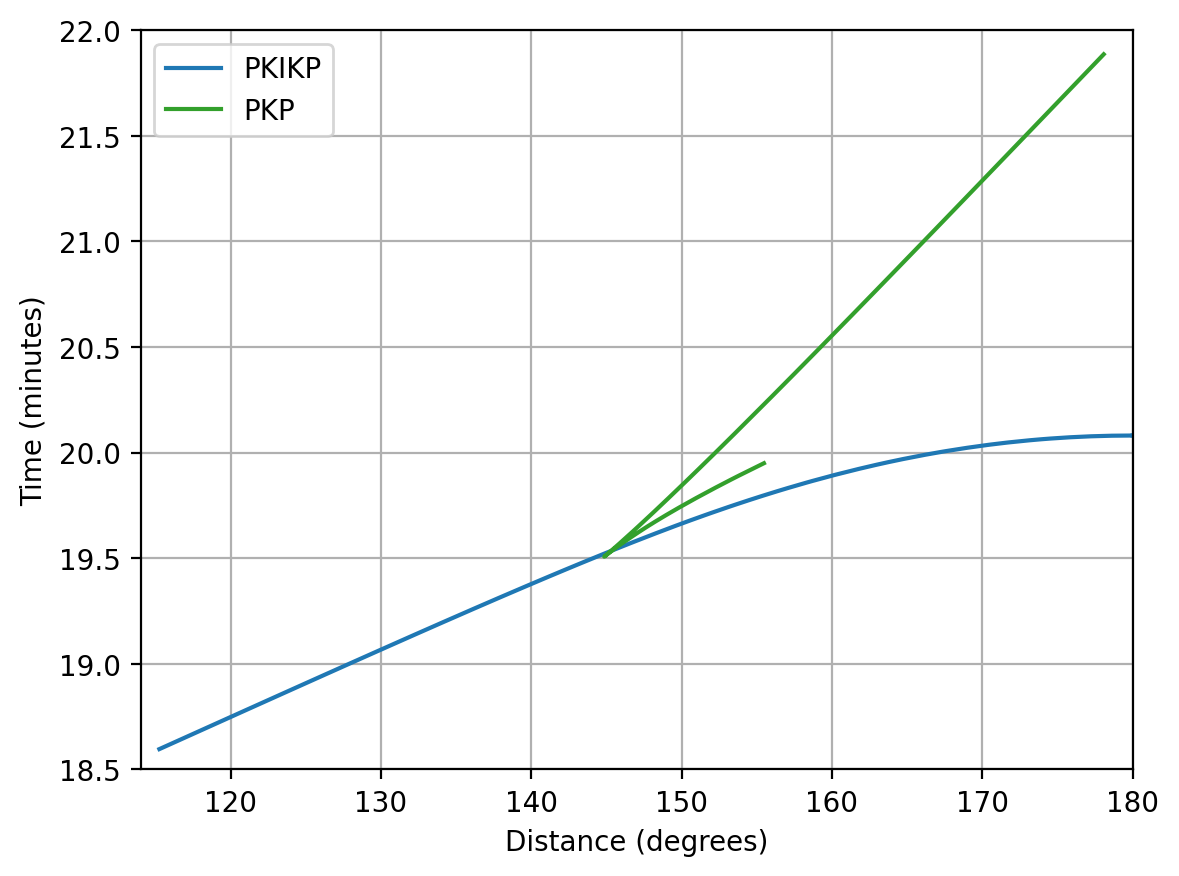

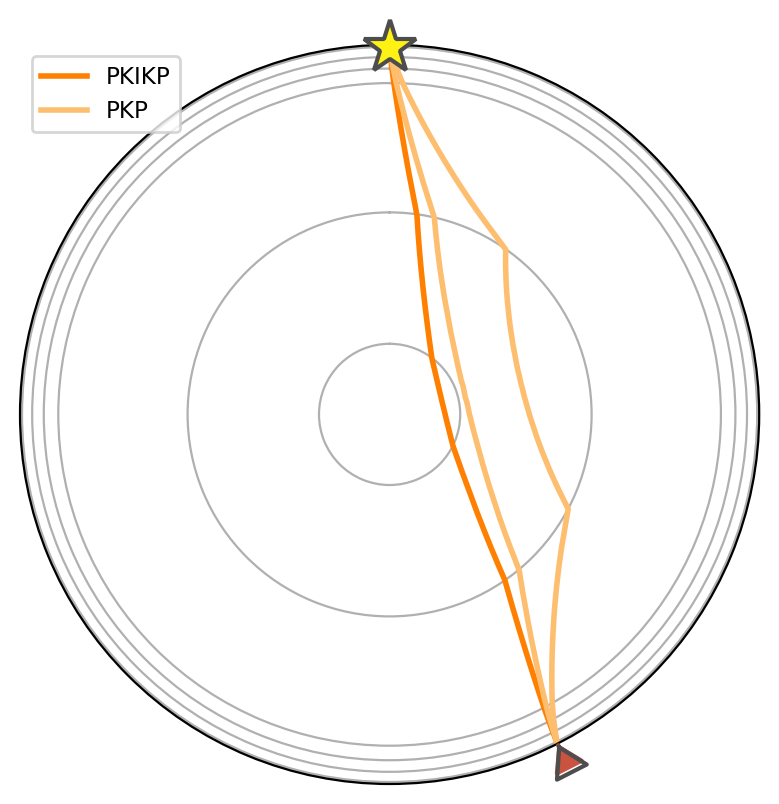

In [30]:
# @title Click for solution
# Import plot_travel_times function
from obspy.taup import plot_travel_times

# Plot travel times for PKP and PKIKP phases
fig, ax = plt.subplots()
plot_travel_times(50, phase_list=['PKP', 'PKIKP'], model='ak135', ax=ax, min_degrees=114, max_degrees=180, show=False)
ax.set(ylim=(18.5, 22))

# Plot ray paths for PKP and PKIKP phases
arrivals = model.get_ray_paths(source_depth_in_km=50, distance_in_degree=153, phase_list=['PKP', 'PKIKP'])
arrivals.plot_rays(plot_type='spherical', legend=True, show=False)
plt.show()

---
## Conclusions
- At high frequency approximation, ray theory can be satisfactorily used to predict travel times and ray paths through Earth's interior.

- Being able to predict travel times and trace ray paths through an 1D Earth model play important roles in seismology (as you will see in the rest of the course).